<a href="https://colab.research.google.com/github/Praveengovianalytics/50DaysofRecomSystem/blob/main/Day9_Rec_System_Ranking_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#50DaysofRecommendationSystems - Day 9

# Day 9 - Agenda

Real-world recommender systems are often composed of two stages:

Retrieval stage :- 

The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.

Ranking stage :-

The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.
We're going to focus on the second stage, ranking. If you are interested in the retrieval stage, have a look at our retrieval tutorial.

In this tutorial, we're going to:- 

*   Get our data and split it into a training and test set
*   Implement a ranking model.
*   Fit and evaluate it.

Note :- RMSE is used as evaluation metric to validate the recommendation engine


In [2]:
!pip install -q tensorflow-recommenders
!pip install -q tensorflow-datasets

In [34]:
import os 
import pprint
import tempfile
import datetime
from typing import Dict,Text
import numpy as np
import tensorflow as tf 
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

# Dataset Preperation

In [5]:
ratings = tfds.load("movielens/100k-ratings",split="train")
ratings = ratings.map(lambda x:{
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
}
)

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incomplete38X9PG/movielens-train.tfrecord


Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


# Test train Split 80 & 20 

In [6]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000,seed=42,reshuffle_each_iteration=False)

train  = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Feature Engineering

#### Raw values of our categorical features to embedding vectors in our models.
To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [9]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])


In [12]:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Neural Network Model Architecture

In [24]:
class RecRankingMod(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))


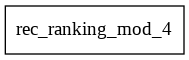

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(RecRankingMod(), show_shapes=True, show_layer_names=True)

In [26]:
RecRankingMod()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03740937]], dtype=float32)>

In [29]:
tasks = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [43]:
class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RecRankingMod()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    rating_predictions = self.ranking_model(
        (features["user_id"], features["movie_title"]))

    # The task computes the loss and the metrics.
    return self.task(labels=features["user_rating"], predictions=rating_predictions)

In [53]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [57]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),metrics=['RMSE'])
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [60]:
model.fit(cached_train, epochs=5)

Epoch 1/5
10/10 [==============================] - 0s 42ms/step - root_mean_squared_error: 1.1084 - loss: 1.2264 - regularization_loss: 0.0000e+00 - total_loss: 1.2264
Epoch 2/5
10/10 [==============================] - 0s 41ms/step - root_mean_squared_error: 1.0935 - loss: 1.1929 - regularization_loss: 0.0000e+00 - total_loss: 1.1929
Epoch 3/5
10/10 [==============================] - 0s 44ms/step - root_mean_squared_error: 1.0723 - loss: 1.1461 - regularization_loss: 0.0000e+00 - total_loss: 1.1461
Epoch 4/5
10/10 [==============================] - 0s 41ms/step - root_mean_squared_error: 1.0466 - loss: 1.0911 - regularization_loss: 0.0000e+00 - total_loss: 1.0911
Epoch 5/5
10/10 [==============================] - 0s 42ms/step - root_mean_squared_error: 1.0210 - loss: 1.0379 - regularization_loss: 0.0000e+00 - total_loss: 1.0379


In [62]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.0131 - loss: 1.0233 - regularization_loss: 0.0000e+00 - total_loss: 1.0233


{'loss': 1.0098752975463867,
 'regularization_loss': 0,
 'root_mean_squared_error': 1.013081431388855,
 'total_loss': 1.0098752975463867}

## Lower the RMSE is better the prediction accuracy of the model

In [61]:
#%tensorboard --logdir logs